> E01: train a trigram language model, i.e. take two characters as an input to predict the 3rd one. Feel free to use either counting or a neural net. Evaluate the loss; Did it improve over a bigram model?

I used counting method to build the trigram. The loss drop from `2.476470470428467` to `2.092747449874878`, which is a good improvement.

> E02: split up the dataset randomly into 80% train set, 10% dev set, 10% test set. Train the bigram and trigram models only on the training set. Evaluate them on dev and test splits. What can you see?

|  | train | test | dev |
| --- | --- | --- | --- |
| bigram | `2.4550743103027344` | `2.454676628112793` | `2.4552478790283203` |
| bigram_nn | `2.4748518466949463` | `2.4748964309692383`| `2.474271774291992` |
| trigram | `2.095414876937866` | `2.1312243938446045` | `2.120994806289673` |
| trigram_nn | `2.398813486099243` | `2.4096901416778564`| `2.402540683746338` |

> E03: use the dev set to tune the strength of smoothing (or regularization) for the trigram model - i.e. try many possibilities and see which one works best based on the dev set loss. What patterns can you see in the train and dev set loss as you tune this strength? Take the best setting of the smoothing and evaluate on the test set once and at the end. How good of a loss do you achieve?

- Best smooth factor for statistics approach: `0.1`
- Best smooth factor for neural network approach: `0.7`

|  | train | test | dev |
| --- | --- | --- | --- |
| trigram | `2.0627923011779785` | `2.116626024246216` | `2.105022430419922` |
| trigram_nn | `2.3957467079162598` | `2.417125940322876` | `2.4003849029541016` |

> E04: we saw that our 1-hot vectors merely select a row of W, so producing these vectors explicitly feels wasteful. Can you delete our use of F.one_hot in favor of simply indexing into rows of W?

Crazy improvement of speed! Time needed for 100 epochs of training from `39.3`s down to just `3.5`s!

> E05: look up and use F.cross_entropy instead. You should achieve the same result. Can you think of why we'd prefer to use F.cross_entropy instead?

It can save a lot of intermediate computation node. 

> E06: meta-exercise! Think of a fun/interesting exercise and complete it.

I add `step` parameter to the `train` function of trigram neural network with cross-entropy loss.

In [2]:
import torch

if torch.backends.mps.is_available():
    # device = torch.device('mps')
    pass

# Data loading

In [3]:
words = open('../../../data/names.txt', 'r').read().splitlines()

In [4]:
words[:10], len(words)

(['emma',
  'olivia',
  'ava',
  'isabella',
  'sophia',
  'charlotte',
  'mia',
  'amelia',
  'harper',
  'evelyn'],
 32033)

In [5]:
g = torch.Generator().manual_seed(2147483647)
trainset, devset, testset = torch.utils.data.random_split(words, [0.8, 0.1, 0.1])

In [6]:
len(trainset), len(devset), len(testset)

(25627, 3203, 3203)

# Trigram neural network

In [11]:
import torch.nn.functional as F
import matplotlib.pyplot as plt

class Bigram_NN:
    def __init__(self):
        g = torch.Generator().manual_seed(2147483647)
        self.W = torch.randn((27, 27), generator=g, requires_grad=True)

    def loaddata(self, dataset):
        chars = sorted(list(set(''.join(dataset))))
        self.stoi = {s:i+1 for i,s in enumerate(chars)}
        self.stoi['.'] = 0
        self.itos = {i:s for s,i in self.stoi.items()}

        xs, ys = [], []

        for w in dataset:
            chs = ['.'] + list(w) + ['.']

            for ch1, ch2 in zip(chs, chs[1:]):
                ix1 = self.stoi[ch1]
                ix2 = self.stoi[ch2]
                xs.append(ix1)
                ys.append(ix2)

        self.xs = torch.tensor(xs)
        self.ys = torch.tensor(ys)

    def forward_pass(self, xs):
        xenc = F.one_hot(xs, num_classes=27).float()
        logits = xenc @ self.W
        counts = logits.exp()
        probs = counts / counts.sum(1, keepdims=True)

        return probs
    
    def train(self, epoch, is_print = True, is_draw = False):
        if is_draw:
            loss_ls = []

        for k in range(epoch):
            self.W.grad = None

            probs = self.forward_pass(self.xs)
            loss = -probs[torch.arange(self.xs.nelement()), self.ys].log().mean() + 0.01*(self.W**2).mean()

            if is_print:
                print('epoch: {} loss: {}'.format(k, loss.item()))

            if is_draw:
                loss_ls.append(loss.item())
            
            loss.backward()

            self.W.data += -50 * self.W.grad

        if is_draw:
            plt.plot(loss_ls)

            plt.title('loss curve')
            plt.grid(linestyle='--')
            plt.xlabel('epoches')
            plt.ylabel('mean negative log-likelihood')

    def sample(self, num):
        g = torch.Generator().manual_seed(2147483647)

        for i in range(num):
            out = []
            ix = 0
            
            # continue token
            while True:
                p = self.forward_pass(torch.tensor([ix, ]))[0]
                ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
                out.append(self.itos[ix])
                
                if ix == 0:
                    break
                
            print(''.join(out))

    def eval(self, dataset, is_print = True):
        log_likelihood = 0.0
        n = 0

        xs, ys = [], []

        for w in dataset:
            chs = ['.'] + list(w) + ['.']

            for ch1, ch2 in zip(chs, chs[1:]):
                ix1 = self.stoi[ch1]
                ix2 = self.stoi[ch2]
                xs.append(ix1)
                ys.append(ix2)

        xs = torch.tensor(xs)
        ys = torch.tensor(ys)
        probs = self.forward_pass(xs)
        log_likelihood = probs[torch.arange(xs.nelement()), ys].log().sum()
        nll = -log_likelihood
        mnll = nll / len(xs)

        if is_print:
            print(f'{log_likelihood=}')
            print(f'{nll=}')
            print(f'{mnll}')

        return mnll

In [8]:
class Trigram_NN(Bigram_NN):
    def __init__(self):
        g = torch.Generator().manual_seed(2147483647)
        self.W = torch.randn((27 * 27, 27), generator=g, requires_grad=True)

    def loaddata(self, dataset):
        chars = sorted(list(set(''.join(dataset))))
        self.stoi = {s:i+1 for i,s in enumerate(chars)}
        self.stoi['.'] = 0
        self.itos = {i:s for s,i in self.stoi.items()}

        xs, ys = [], []

        for w in dataset:
            chs = ['.'] + list(w) + ['.']

            for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
                ix1 = self.stoi[ch1]
                ix2 = self.stoi[ch2]
                ix3 = self.stoi[ch3]
                xs.append(27 * ix1 + ix2)
                ys.append(ix3)

        self.xs = torch.tensor(xs)
        self.ys = torch.tensor(ys)

    def forward_pass(self, xs):
        xenc = F.one_hot(xs, num_classes=27 * 27).float()
        logits = xenc @ self.W
        counts = logits.exp()
        probs = counts / counts.sum(1, keepdims=True)

        return probs

    def sample(self, num):
        g = torch.Generator().manual_seed(2147483647)

        for i in range(num):
            out = []
            ixs = self.xs[self.xs < 27]
            idx_rand = torch.randint(len(ixs), (1, ))
            ix = ixs[idx_rand]
            
            # continue token
            while True:
                p = self.forward_pass(torch.tensor([ix, ]))[0]
                ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
                out.append(self.itos[ix])
                
                if ix == 0:
                    break
                
            print(''.join(out))

    def eval(self, dataset, is_print = True):
        log_likelihood = 0.0
        n = 0

        xs, ys = [], []

        for w in dataset:
            chs = ['.'] + list(w) + ['.']

            for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
                ix1 = self.stoi[ch1]
                ix2 = self.stoi[ch2]
                ix3 = self.stoi[ch3]
                xs.append(27 * ix1 + ix2)
                ys.append(ix3)

        xs = torch.tensor(xs)
        ys = torch.tensor(ys)
        probs = self.forward_pass(xs)
        log_likelihood = probs[torch.arange(xs.nelement()), ys].log().sum()
        nll = -log_likelihood
        mnll = nll / len(xs)

        if is_print:
            print(f'{log_likelihood=}')
            print(f'{nll=}')
            print(f'{mnll}')

        return mnll

In [9]:
class Trigram_NN_tune(Trigram_NN):
    def train(self, epoch, smooth_factor = 0.01, is_print = True, is_draw = False):
        if is_draw:
            loss_ls = []

        for k in range(epoch):
            self.W.grad = None

            probs = self.forward_pass(self.xs)
            loss = -probs[torch.arange(self.xs.nelement()), self.ys].log().mean() + smooth_factor * (self.W**2).mean()

            if is_print:
                print('epoch: {} loss: {}'.format(k, loss.item()))

            if is_draw:
                loss_ls.append(loss.item())
            
            loss.backward()

            self.W.data += -50 * self.W.grad

        if is_draw:
            plt.plot(loss_ls)

            plt.title('loss curve')
            plt.grid(linestyle='--')
            plt.xlabel('epoches')
            plt.ylabel('mean negative log-likelihood')

# Trigram neural network without 1-hot input

In [22]:
class Trigram_NN_x1hot(Trigram_NN_tune):
    def forward_pass(self, xs):
        logits = torch.index_select(self.W, 0, xs)
        counts = logits.exp()
        probs = counts / counts.sum(1, keepdims=True)

        return probs

In [23]:
trigram_nn = Trigram_NN_x1hot()
trigram_nn.loaddata(trainset)
trigram_nn.train(100, is_print=False, is_draw=False, smooth_factor=0.7)

In [37]:
print('='*50 + '\ntrain\n' + '-'*50)
trigram_nn.eval(trainset)

print('='*50 + '\ndev\n' + '-'*50)
trigram_nn.eval(devset)

print('='*50 + '\ntest\n' + '-'*50)
trigram_nn.eval(testset)

train
--------------------------------------------------
log_likelihood=tensor(-375974.1250, grad_fn=<SumBackward0>)
nll=tensor(375974.1250, grad_fn=<NegBackward0>)
2.3957467079162598
dev
--------------------------------------------------
log_likelihood=tensor(-47283.8164, grad_fn=<SumBackward0>)
nll=tensor(47283.8164, grad_fn=<NegBackward0>)
2.417125940322876
test
--------------------------------------------------
log_likelihood=tensor(-47088.3516, grad_fn=<SumBackward0>)
nll=tensor(47088.3516, grad_fn=<NegBackward0>)
2.4003849029541016


tensor(2.4004, grad_fn=<DivBackward0>)

# Trigram neural network with cross-entropy

In [50]:
class Trigram_NN_cross_entropy(Trigram_NN_x1hot):
    def forward_pass(self, xs):
        return torch.index_select(self.W, 0, xs)
    
    def probs(self, xs):
        logits = torch.index_select(self.W, 0, xs)
        counts = logits.exp()
        probs = counts / counts.sum(1, keepdims=True)

        return probs

    def train(self, epoch, is_print = True, is_draw = False, smooth_factor = 0.01, step = 50):
        if is_draw:
            loss_ls = []

        for k in range(epoch):
            self.W.grad = None

            logits = self.forward_pass(self.xs)
            loss = F.cross_entropy(logits, self.ys) + smooth_factor * (self.W**2).mean()

            if is_print:
                print('epoch: {} loss: {}'.format(k, loss.item()))

            if is_draw:
                loss_ls.append(loss.item())
            
            loss.backward()

            self.W.data += -step * self.W.grad

        if is_draw:
            plt.plot(loss_ls)

            plt.title('loss curve')
            plt.grid(linestyle='--')
            plt.xlabel('epoches')
            plt.ylabel('mean negative log-likelihood')

    def sample(self, num):
        g = torch.Generator().manual_seed(2147483647)

        for i in range(num):
            out = []
            ixs = self.xs[self.xs < 27]
            idx_rand = torch.randint(len(ixs), (1, ))
            ix = ixs[idx_rand]
            
            # continue token
            while True:
                p = self.probs(torch.tensor([ix, ]))[0]
                ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
                out.append(self.itos[ix])
                
                if ix == 0:
                    break
                
            print(''.join(out))

    def eval(self, dataset, is_print = True):
        log_likelihood = 0.0
        n = 0

        xs, ys = [], []

        for w in dataset:
            chs = ['.'] + list(w) + ['.']

            for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
                ix1 = self.stoi[ch1]
                ix2 = self.stoi[ch2]
                ix3 = self.stoi[ch3]
                xs.append(27 * ix1 + ix2)
                ys.append(ix3)

        xs = torch.tensor(xs)
        ys = torch.tensor(ys)
        probs = self.probs(xs)
        log_likelihood = probs[torch.arange(xs.nelement()), ys].log().sum()
        nll = -log_likelihood
        mnll = nll / len(xs)

        if is_print:
            print(f'{log_likelihood=}')
            print(f'{nll=}')
            print(f'{mnll}')

        return mnll

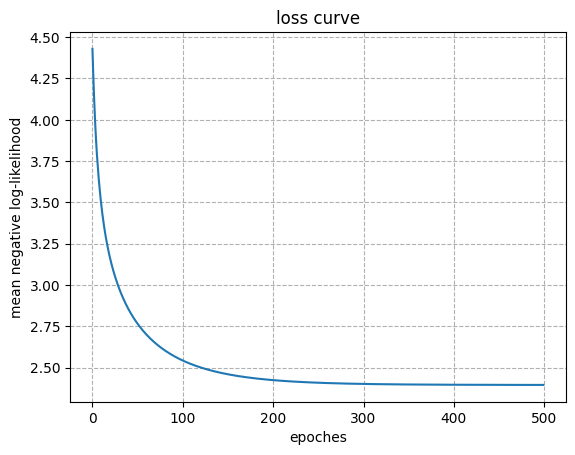

In [51]:
trigram_nn = Trigram_NN_cross_entropy()
trigram_nn.loaddata(trainset)
trigram_nn.train(500, is_print=False, is_draw=True, smooth_factor=0.7, step=100)
# trigram_nn.train(100, is_print=False, is_draw=True)

In [52]:
trigram_nn.sample(5)

luwidediliaqazoprofayoadanavaiiritolemasarezavilanaauyamileviaskdbdainrwimelesejainayvarolofavaumaryfoltumjanonasuwahamanirhoraayaezocarajaabriwedemiifmayfinevisasnhaviimomazahadgosfmananoilu.
elemalaryatiryareli.
isamuyerumjemujemaluupwyalevavcararorydahufrortanapayosbrevisuiqzavmaocblihamimayawathf.
anelaloleshatikemsaloevevinanolwkfabrenemadanolaryawimuralodridrdzeolialilpargraitezraleliquvywhqelvaviosahibrhauelazmimwisasabarinaliwalipixtewyosgrewfdadenelavjankesoranajresadomanolyabrelihanazyodabrufuolwiasatelytilabujadasavenjayalyudfrequladoshatalalokamalefadmanistfalamadedihavigaojarasyqiviob.
uzisugogidenalgujhamovrafrlaglyuraluohanotraryalirsoirevihaipalkanvjapashizamaulnaneicvatavryaelashbrlazsalauyalihouejbiotzyproabhihadisaubralamorvanarauuzalazyarhavrolisabadayraufbraqdocowyalabzazevadanohanokemetamlelelonakanyinaastanitcyonanisemyanawwisxilemcharekanaljagkjamifizafaminayaularovyab.


In [53]:
print('='*50 + '\ntrain\n' + '-'*50)
trigram_nn.eval(trainset)

print('='*50 + '\ndev\n' + '-'*50)
trigram_nn.eval(devset)

print('='*50 + '\ntest\n' + '-'*50)
trigram_nn.eval(testset)

train
--------------------------------------------------
log_likelihood=tensor(-350730.3125, grad_fn=<SumBackward0>)
nll=tensor(350730.3125, grad_fn=<NegBackward0>)
2.2348904609680176
dev
--------------------------------------------------
log_likelihood=tensor(-44216.3203, grad_fn=<SumBackward0>)
nll=tensor(44216.3203, grad_fn=<NegBackward0>)
2.260316848754883
test
--------------------------------------------------
log_likelihood=tensor(-44072.6055, grad_fn=<SumBackward0>)
nll=tensor(44072.6055, grad_fn=<NegBackward0>)
2.2466537952423096


tensor(2.2467, grad_fn=<DivBackward0>)